# Graded Lab 2: CIFAR-10 Challenge

In this lab you will experiment with whatever ConvNet architecture/design you'd like on [CIFAR-10 image dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

### Group#: 1

 - Jibin George (0832593)
 - Jibin Kuruppassery Sebastian (0829897)
 - Kailas Krishnan Radhakrishnan Sudhadevi (0850313)
 - Vishal Ramesh Babu (0832438)


## What to submit

 - A completed .ipynb file with all code executed and all output visible
 - A PDF/HTML version of the above file

## Part 1: Creating the network (50% of grade)

**Goal:** After training, your model should achieve **at least 80%** accuracy on a **validation** set within 20 epochs. (Or as close as possible as long as there is demonstrated effort to achieve this goal.)

**Data split** The training set should consist of 40000 images, the validation set should consist of 10000 images, and the test set should consist of the remaining 10000 images. **Please use the Keras `load_data()` function to import the data set.**


**Implementation** All code should be in Keras/python.

### Some things you can try:
- Different number/type of layers
- Different filter sizes
- Adjust the number of filters used in any given layer
- Try various pooling strategies
- Consider using batch normalization
- Check if adding regularization helps
- Consider alternative optimizers
- Try different activation functions


### Tips for training
When building/tuning your model, keep in mind the following points:

- This is experimental, so be driven by results achieved on the validation set as opposed to what you have heard/read works well or doesn't
- If the hyperparameters are working well, you should see improvement in the loss/accuracy within approximately one epoch
- For hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all
- Once you have found some sets of hyperparameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- Prefer random search to grid search for hyperparameters
- You should use the validation set for hyperparameter search and for evaluating different architectures
- The test set should only be used at the very end to evaluate your final model

### What to provide

The cell below should contain all the code necessary to run your final network on the cifar10 dataset as contained within Keras. All necessary hyperparameters should be visible either in the code or through comments. Your code should include 2 plots: one for training and validation loss per epoch and one for training and validation accuracy per epoch.  

Your network should produce an accuracy of at least 80% on the validation set within 20 epochs. (Or as close as possible as long as there is demonstrated effort to achieve this goal.)

You should also evaluate and report the accuracy on the test set. The test set should be used only once. That is, after you have decided on what to include in your network and tuned any hyperparameters for your final network, you should use this final network on the test set and calculate the accuracy.  

**Please make sure that all code has been run and the output is visible in the notebook before submitting.**

**Please note that I should be able to run the single code cell below and reproduce your results.**

**All code should be in ONE code cell.**

In [14]:
from keras.layers import Input, Dense, Rescaling, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint

from keras.applications import VGG16, ResNet50
from keras.applications import resnet, vgg16
from keras.datasets.cifar10 import load_data

from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import keras_tuner, keras
import tensorflow as tf

In [2]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [3]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 1), (10000, 1))

In [4]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [5]:
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')  

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Base Model

Creating a baseline model with two blocks where each block contains 2 Conv2D + 1 Pool layer, all with 32 filters and the same padding. For the classification layer, there are 2 hidden layers, each with 128 nuerons, and an output layer. The batch size is set to 32 and epochs to 10.

In [7]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_1')(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_2')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'pool_1')(x)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_3')(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_4')(x)
x = AveragePooling2D(pool_size = (2,2), strides = 2, name = 'pool_2')(x)

x = Flatten(name = 'flatten')(x)
x = Dense(128, activation = 'relu', name = 'fc_1')(x)
x = Dense(128, activation = 'relu', name = 'fc_2')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_baseline/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    base_model = network.fit(train_images, train_labels, epochs = 10, batch_size = 32, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 16, 16, 32)        9248      
                                                                 
 conv_4 (Conv2D)             (None, 16, 16, 32)        9248  

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(base_model.history['accuracy'], marker = '*')
ax1.plot(base_model.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(base_model.history['loss'], marker = '*')
ax2.plot(base_model.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observation**

- The validation accuracy is 73%. May be increasing the number of epochs, reducing the batch size and adding one more block of convolution can improve the performance.

### Model - 2

In [9]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_1')(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_2')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'pool_1')(x)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_3')(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_4')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'pool_2')(x)

x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_5')(x)
x = Conv2D(32, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'conv_6')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'pool_3')(x)

x = Flatten(name = 'flatten')(x)
x = Dense(128, activation = 'relu', name = 'fc_1')(x)
x = Dense(128, activation = 'relu', name = 'fc_2')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_model_2/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_2 = network.fit(train_images, train_labels, epochs = 20, batch_size = 16, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 pool_1 (MaxPooling2D)       (None, 16, 16, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 16, 16, 32)        9248      
                                                                 
 conv_4 (Conv2D)             (None, 16, 16, 32)        9248

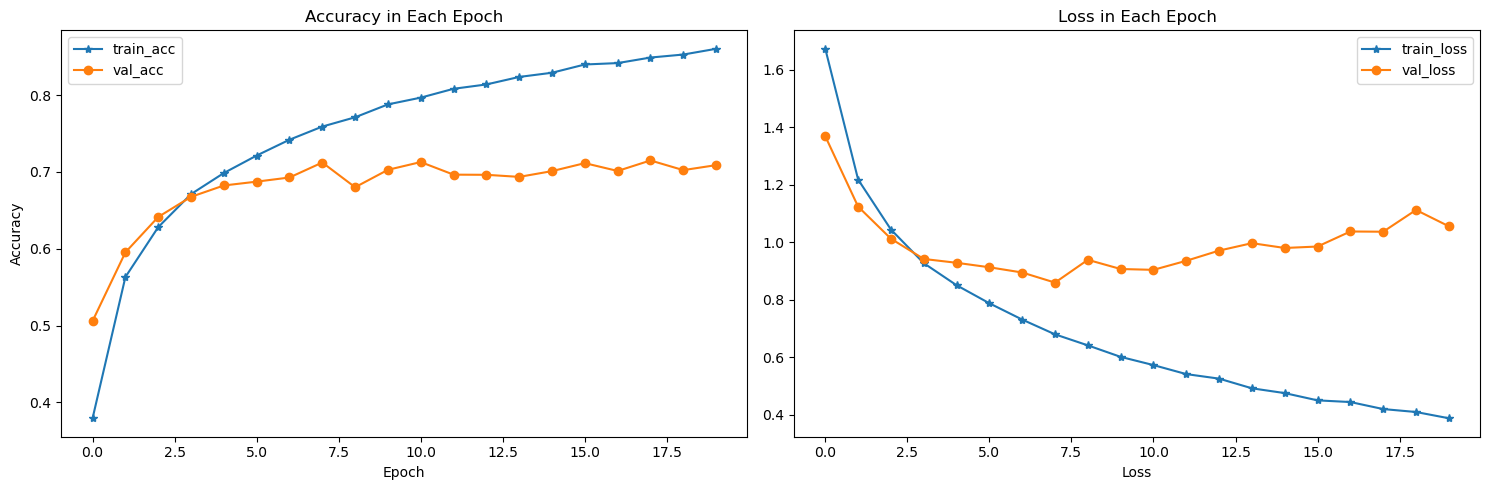

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_2.history['accuracy'], marker = '*')
ax1.plot(model_2.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_2.history['loss'], marker = '*')
ax2.plot(model_2.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observation**
- There is no improvement in the model after the changes. Using a pretrained model VGG16.

### Model - 3

In [16]:
conv_base_vgg16 = VGG16(include_top = False, input_shape = (32, 32, 3))
conv_base_vgg16.trainable =  False

In [17]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)
x = vgg16.preprocess_input(x)
x = conv_base_vgg16(x)

x = Flatten(name = 'flatten')(x)
x = Dense(128, activation = 'relu', name = 'fc_1')(x)
x = Dense(128, activation = 'relu', name = 'fc_2')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_model_3/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_3 = network.fit(train_images, train_labels, epochs = 20, batch_size = 16, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 32, 32, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0   

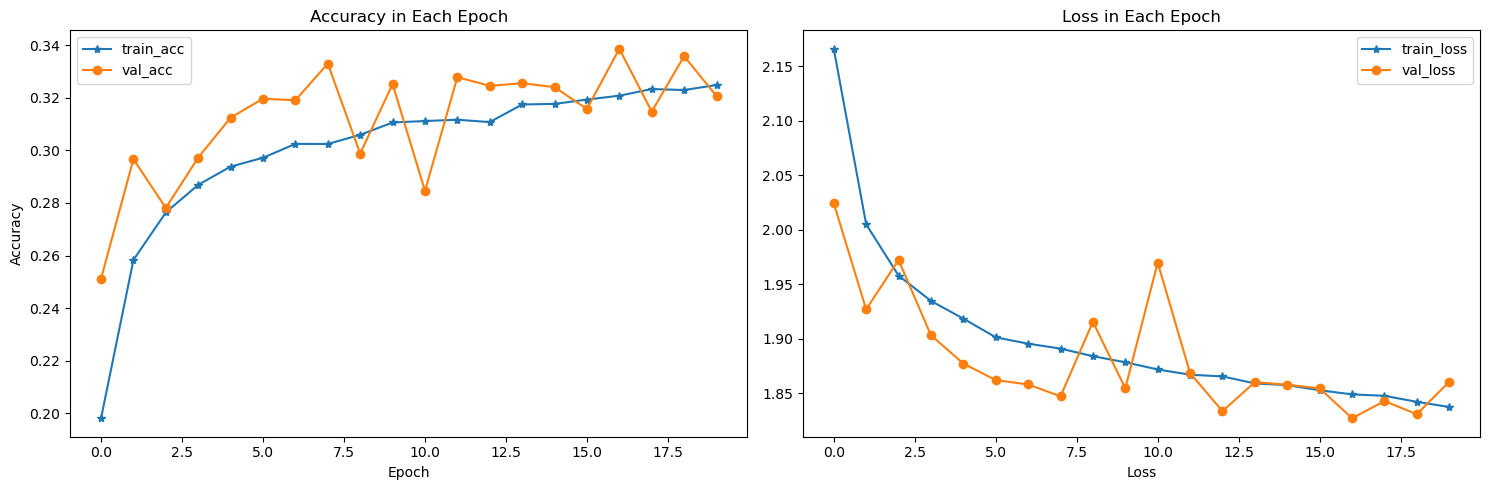

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_3.history['accuracy'], marker = '*')
ax1.plot(model_3.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_3.history['loss'], marker = '*')
ax2.plot(model_3.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observation**

There is no improvement in the model after using VGG16 and the variations in loss and accuracy is very high. Switching to ResNet50.

### Model - 4

In [19]:
conv_base_resnet = ResNet50(include_top = False, input_shape = (32, 32, 3))
conv_base_resnet.trainable =  False

94765736/94765736 [==============================] - 11s 0us/step


In [20]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)
x = resnet.preprocess_input(x)
x = conv_base_resnet(x)

x = Flatten(name = 'flatten')(x)
x = Dense(128, activation = 'relu', name = 'fc_1')(x)
x = Dense(128, activation = 'relu', name = 'fc_2')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_model_4/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_4 = network.fit(train_images, train_labels, epochs = 20, batch_size = 16, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 tf.__operators__.getitem_2   (None, 32, 32, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0   

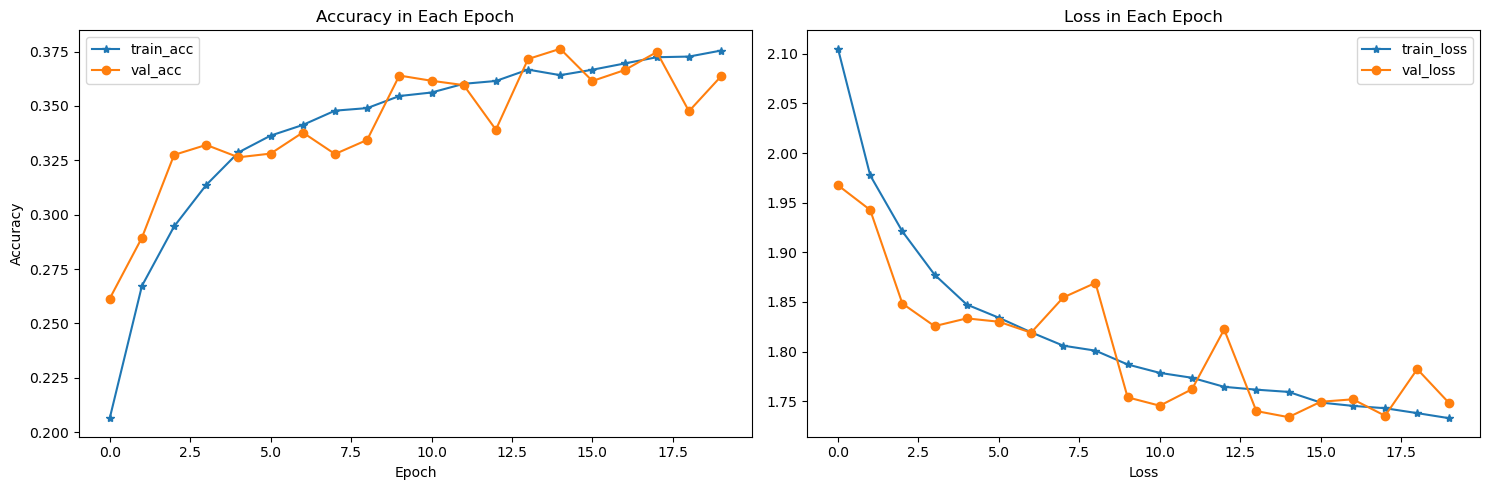

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_4.history['accuracy'], marker = '*')
ax1.plot(model_4.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_4.history['loss'], marker = '*')
ax2.plot(model_4.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observatiion**
- There is only a slight improvement in accuracy even after using ResNet50. Trying to use keras tuner to improve the performance.

### Model - 5

In [23]:
def build_model_5(hp):
    model = Sequential()
    model.add(Input(shape = (32, 32, 3)))
    model.add(Rescaling(scale = 1./255))

    for i in range(hp.Int("num_block1_layers", 1, 5)):
        model.add(
            Conv2D(
                filters = hp.Int(f"block1_filters_{i}", min_value = 32, max_value = 256, step = 32),
                kernel_size = hp.Choice(f"block1_kernel_size_{i}", [3, 5]),
                padding = 'same',
                activation = 'relu'
            )
        )
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    for k in range(hp.Int("num_block2_layers", 1, 5)):
        model.add(
            Conv2D(
                filters = hp.Int(f"block2_filters_{k}", min_value = 32, max_value = 256, step = 32),
                kernel_size = hp.Choice(f"block2_kernel_size_{k}", [3, 5]),
                padding = 'same',
                activation = 'relu'
            )
        )
    model.add(MaxPooling2D(pool_size = (2,2), strides = 2))

    model.add(Flatten())

    for j in range(hp.Int("num_dense_layers", 1, 7)):
        model.add(
          Dense(
              units = hp.Int(f"units_{j}", min_value = 32, max_value = 512, step = 32),
              activation = 'relu'
          )
        )

    model.add(Dense(10, activation = 'softmax'))

    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")

    optimizer_choice = hp.Choice("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_choice == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimizer_choice == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate = learning_rate)

    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

    return model


tuner = keras_tuner.RandomSearch(
    hypermodel = build_model_5,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 2,
    overwrite = True,
    directory = "model_5",
    project_name = "tuner_models"
)

with tf.device('/GPU:0'):
    model_5 = tuner.search(train_images, train_labels, epochs = 20, batch_size = 16, validation_split = 0.2)

print("Using GPU:", tf.test.is_built_with_cuda())

Trial 10 Complete [01h 23m 22s]
val_accuracy: 0.6683000028133392

Best val_accuracy So Far: 0.7450500130653381
Total elapsed time: 12h 20m 23s
Using GPU: True


In [24]:
best_hps = tuner.get_best_hyperparameters()

network = build_model_5(best_hps[0])
network.summary()

callbacks = ModelCheckpoint(filepath = "convnet_model_5_after_tuner/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_5 = network.fit(train_images, train_labels, epochs = 20, batch_size = 16, validation_split = 0.2, callbacks = [callbacks])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)            

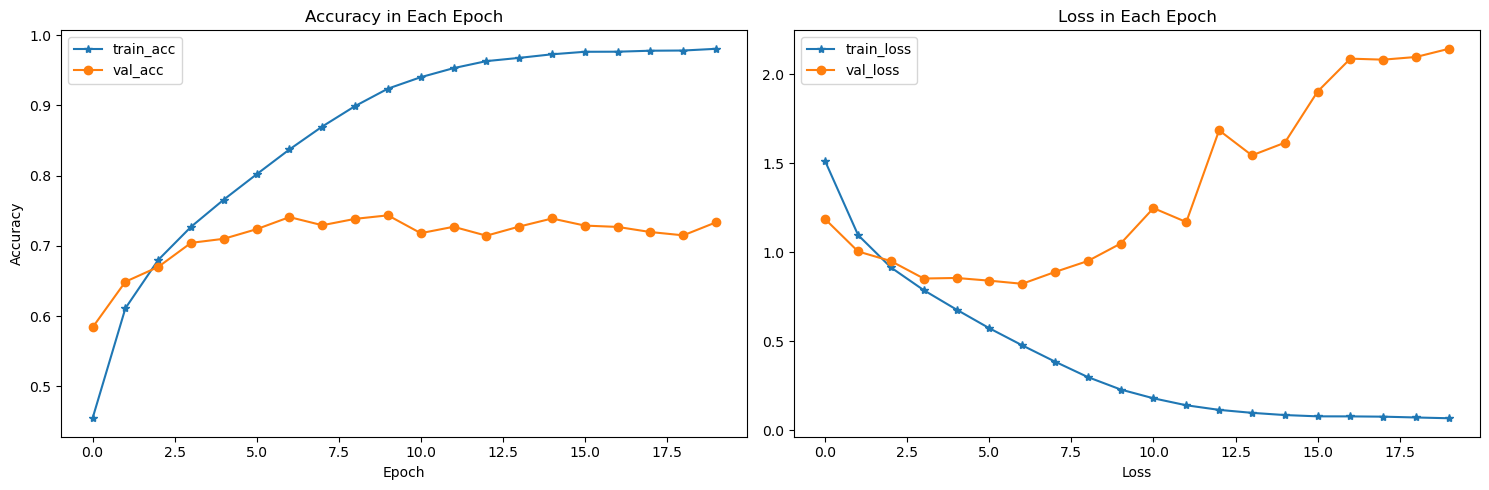

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_5.history['accuracy'], marker = '*')
ax1.plot(model_5.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_5.history['loss'], marker = '*')
ax2.plot(model_5.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observation**
- The validation accuracy is still 71%. Keeping the max_trials to 10 and adding an option to choose between max pooling and average pooling.

### Model - 6

In [26]:
def build_model_6(hp):
    model = Sequential()
    model.add(Input(shape = (32, 32, 3)))
    model.add(Rescaling(scale = 1./255))
    
    for i in range(hp.Int("num_block1_layers", 1, 5)):
        model.add(
            Conv2D(
                filters = hp.Int(f"block1_filters_{i}", min_value = 32, max_value = 256, step = 32),
                kernel_size = hp.Choice(f"block1_kernel_size_{i}", [3, 5]),
                padding = 'same',
                activation = 'relu'
            )
        )
    
    pooling_layer = hp.Choice(f"pooling_type{i}", ["avg", "max"])
    if pooling_layer == "avg":
        model.add(AveragePooling2D(pool_size = (2,2), strides = 2))
    else:
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    
    for k in range(hp.Int("num_block2_layers", 1, 5)):
        model.add(
            Conv2D(
                filters = hp.Int(f"block2_filters_{k}", min_value = 32, max_value = 256, step = 32),
                kernel_size = hp.Choice(f"block2_kernel_size_{k}", [3, 5]),
                padding = 'same',
                activation = 'relu'
            )
        )
    
    pooling_layer = hp.Choice(f"pooling_type{k}", ["avg", "max"])
    if pooling_layer == "avg":
        model.add(AveragePooling2D(pool_size = (2,2), strides = 2))
    else:
        model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
    
    model.add(Flatten())
    
    for j in range(hp.Int("num_dense_layers", 1, 7)):
        model.add(
          Dense(
              units = hp.Int(f"units_{j}", min_value = 32, max_value = 512, step = 32),
              activation = 'relu'
          )
        )
    
    model.add(Dense(10, activation = 'softmax'))
    
    learning_rate = hp.Float("lr", min_value = 1e-4, max_value = 1e-2, sampling = "log")
    
    optimizer_choice = hp.Choice("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_choice == 'Adam':
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    elif optimizer_choice == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate = learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate = learning_rate)
    
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model


tuner = keras_tuner.RandomSearch(
    hypermodel = build_model_6,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 2,
    overwrite = True,
    directory = "model_6",
    project_name = "tuner_models"
)

with tf.device('/GPU:0'):
    model_6 = tuner.search(train_images, train_labels, epochs = 20, batch_size = 8, validation_split = 0.2)

print("Using GPU:", tf.test.is_built_with_cuda())

Trial 10 Complete [02h 07m 13s]
val_accuracy: 0.6200999915599823

Best val_accuracy So Far: 0.7324999868869781
Total elapsed time: 18h 28m 15s
Using GPU: True


In [27]:
best_hps = tuner.get_best_hyperparameters()

network = build_model_6(best_hps[0])
network.summary()

callbacks = ModelCheckpoint(filepath = "convnet_model_6_after_tuner/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_6 = network.fit(train_images, train_labels, epochs = 20, batch_size = 8, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 160)       12160     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        46112     
                                                                 
 average_pooling2d_1 (Averag  (None, 16, 16, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 256)       409856    
                                                      

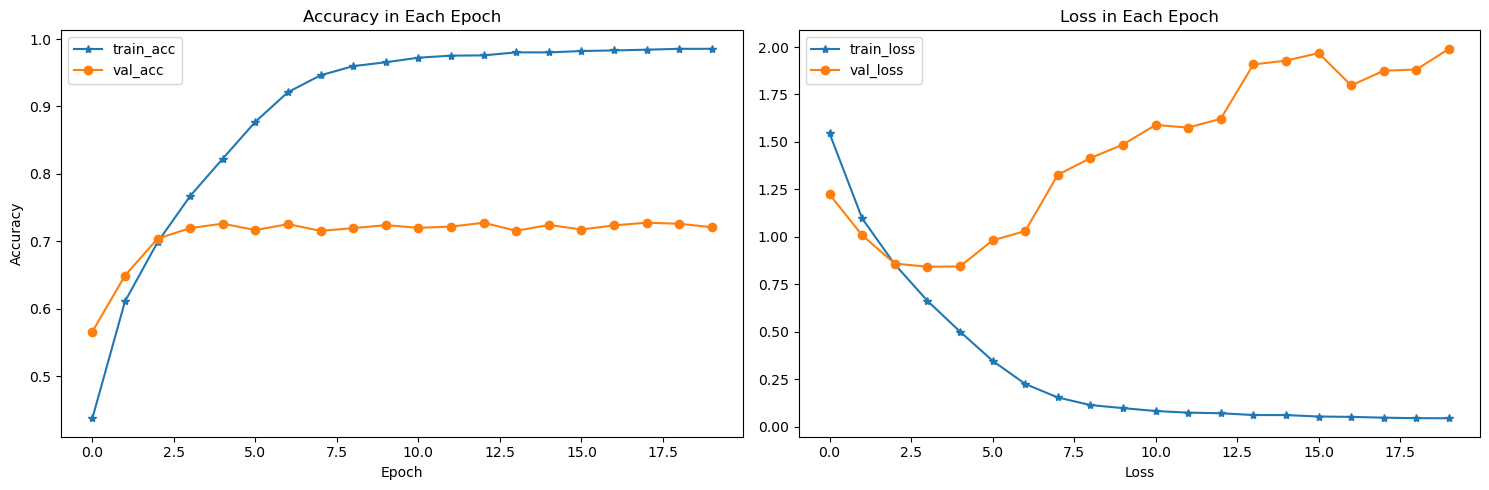

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_6.history['accuracy'], marker = '*')
ax1.plot(model_6.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_6.history['loss'], marker = '*')
ax2.plot(model_6.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observations**
- Using an architecture combined from both the tuner searches and adding a kernel regularizer to all the layers inorder to prevent the overfitting.

### Model - 7

In [12]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)

x = Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_1-conv_1', kernel_regularizer = l2(1e-4))(x)
x = Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_1-conv_2', kernel_regularizer = l2(1e-4))(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_1-pool_1')(x)

x = Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_2-conv_1', kernel_regularizer = l2(1e-4))(x)
x = Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_2-conv_2', kernel_regularizer = l2(1e-4))(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_2-pool_1')(x)

x = Conv2D(512, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_3-conv_1', kernel_regularizer = l2(1e-4))(x)
x = Conv2D(512, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_3-conv_2', kernel_regularizer = l2(1e-4))(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_3-pool_1')(x)

x = Flatten(name = 'flatten')(x)
x = Dense(512, activation = 'relu', name = 'fc_1', kernel_regularizer = l2(1e-4))(x)
x = Dense(512, activation = 'relu', name = 'fc_2', kernel_regularizer = l2(1e-4))(x)
x = Dense(256, activation = 'relu', name = 'fc_3', kernel_regularizer = l2(1e-4))(x)
x = Dense(256, activation = 'relu', name = 'fc_4')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_model_7/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_7 = network.fit(train_images, train_labels, epochs = 20, batch_size = 8, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block_1-conv_1 (Conv2D)     (None, 32, 32, 128)       3584      
                                                                 
 block_1-conv_2 (Conv2D)     (None, 32, 32, 128)       147584    
                                                                 
 block_1-pool_1 (MaxPooling2  (None, 16, 16, 128)      0         
 D)                                                              
                                                                 
 block_2-conv_1 (Conv2D)     (None, 16, 16, 256)       295168    
                                                           

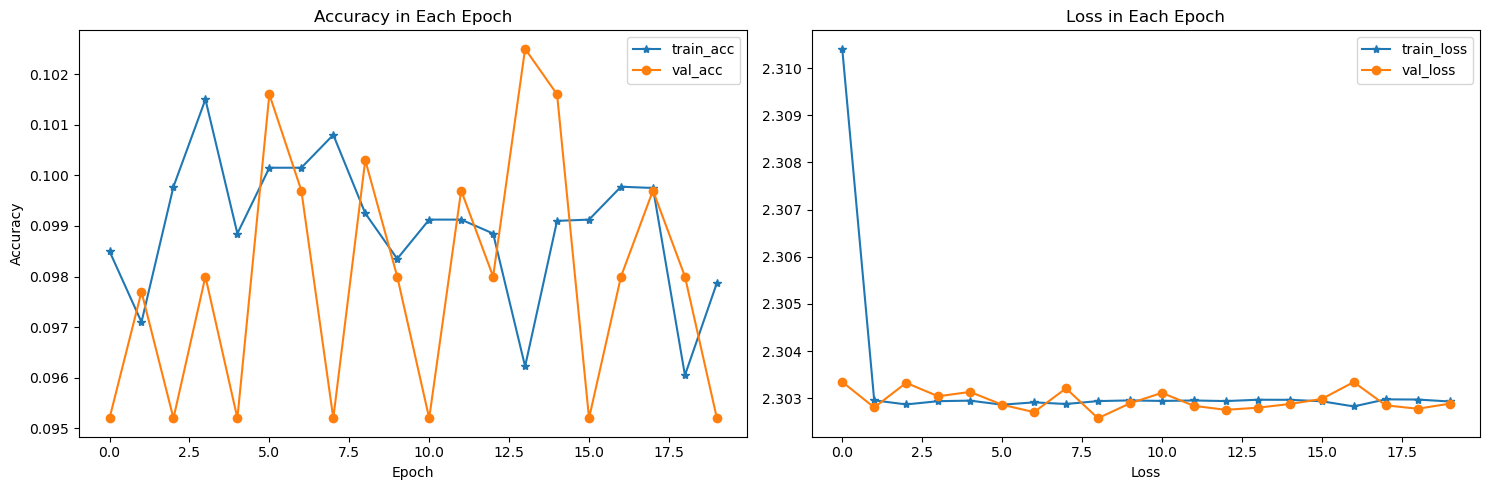

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_7.history['accuracy'], marker = '*')
ax1.plot(model_7.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_7.history['loss'], marker = '*')
ax2.plot(model_7.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observations**
- There is no increase in accuracy. Trying batch normalization and dropout layers in the same architecture.

### Model - 8

In [19]:
inp = Input(shape = (32, 32, 3), name = 'input')
x = Rescaling(scale = 1./255, name = 'rescaling')(inp)

x = Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_1-conv_1', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_1-norm_1')(x)
x = Conv2D(128, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_1-conv_2', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_1-norm_2')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_1-pool_1')(x)
x = Dropout(0.2, name = 'block_1-drop_1')(x)

x = Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_2-conv_1', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_2-norm_1')(x)
x = Conv2D(256, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_2-conv_2', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_2-norm_2')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_2-pool_1')(x)
x = Dropout(0.3, name = 'block_2-drop_1')(x)

x = Conv2D(512, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_3-conv_1', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_3-norm_1')(x)
x = Conv2D(512, kernel_size = (3,3), padding = 'same', activation = 'relu', name = 'block_3-conv_2', kernel_regularizer = l2(1e-4))(x)
x = BatchNormalization(name = 'block_3-norm_2')(x)
x = MaxPooling2D(pool_size = (2,2), strides = 2, name = 'block_3-pool_1')(x)

x = Flatten(name = 'flatten')(x)
x = Dense(512, activation = 'relu', name = 'fc_1', kernel_regularizer = l2(1e-4))(x)
x = Dense(512, activation = 'relu', name = 'fc_2', kernel_regularizer = l2(1e-4))(x)
x = Dense(256, activation = 'relu', name = 'fc_3', kernel_regularizer = l2(1e-4))(x)
x = Dense(256, activation = 'relu', name = 'fc_4')(x)
out = Dense(10, activation = 'softmax', name = 'output')(x)

network = Model(inputs = inp, outputs = out)
network.summary()

network.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

callbacks = ModelCheckpoint(filepath = "convnet_model_8/model_{epoch:02d}.keras", monitor = 'val_accuracy', mode = 'max')

with tf.device('/GPU:0'):
    model_8 = network.fit(train_images, train_labels, epochs = 20, batch_size = 8, validation_split = 0.2, callbacks = [callbacks])

print("Using GPU:", tf.test.is_built_with_cuda())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block_1-conv_1 (Conv2D)     (None, 32, 32, 128)       3584      
                                                                 
 block_1-norm_1 (BatchNormal  (None, 32, 32, 128)      512       
 ization)                                                        
                                                                 
 block_1-conv_2 (Conv2D)     (None, 32, 32, 128)       147584    
                                                                 
 block_1-norm_2 (BatchNormal  (None, 32, 32, 128)      512       
 ization)                                                  

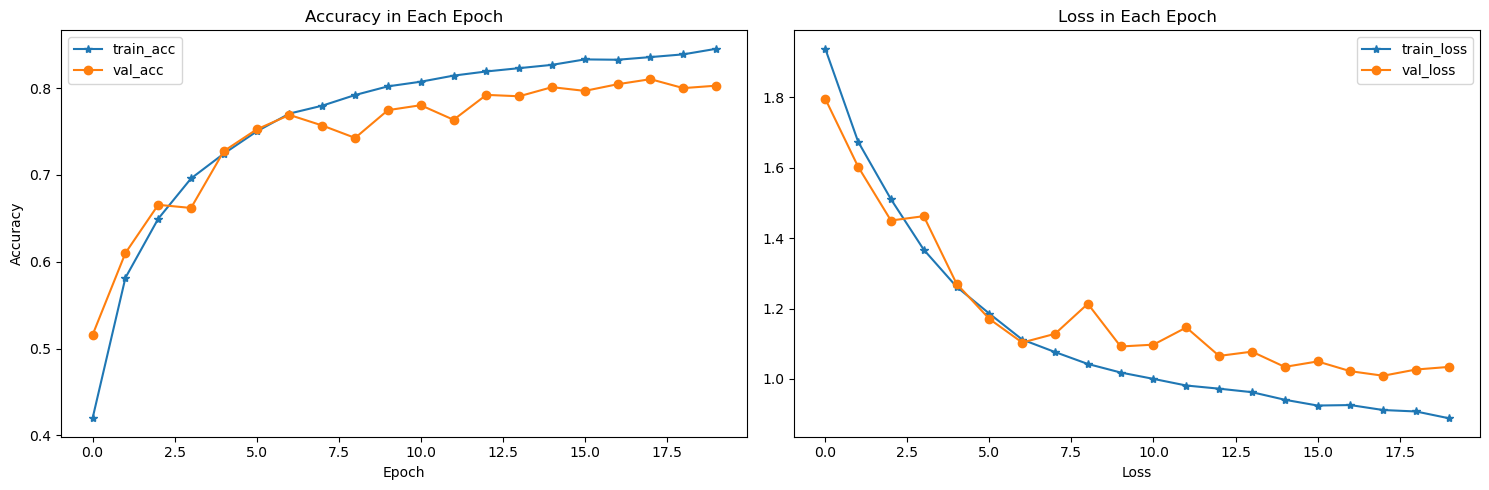

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(model_8.history['accuracy'], marker = '*')
ax1.plot(model_8.history['val_accuracy'], marker = 'o')
ax1.legend(["train_acc", "val_acc"])
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy in Each Epoch")

ax2.plot(model_8.history['loss'], marker = '*')
ax2.plot(model_8.history['val_loss'], marker = 'o')
ax2.legend(["train_loss", "val_loss"])
ax2.set_xlabel("Epoch")
ax2.set_xlabel("Loss")
ax2.set_title("Loss in Each Epoch")

plt.tight_layout()
plt.show()

**Observations**
- Model is having a good training accuracy as well as validation accuracy. Choosing this as the final model.

In [25]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

313/313 [==============================] - 5s 17ms/step - loss: 1.0594 - accuracy: 0.7995


**Observations**
- The final model has an accuracy score of 79% for the test data.

## Part 2: Describe What you did (50% of grade)

All the work you did leading up to your final model should be summarized in this section. This should be a logical and well-organized summary of the various experiments that were tried in **Part 1**, and should be captured in **table format**. Upon reading this section I should understand what you tried, the reasoning behind trying it, any quantitative values that correspond to what you tried, and the results.

See [this guide](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook) for how to format markdown cells in Jupyter notebooks.

| Network | No of Conv Layers | No of Filters/Layer | Pooling | No of Dense Layers| No. Neurons/Layer | Batch Size | No. Epochs | Dropout (Y/N) | BatchNormalization (Y/N) | Trainable Parameters | Non Trainable Parameters | Pretrained Model | Kernel Regularizer | Training Accuracy | Validation Accuracy | Training Loss | Validation Loss | 
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:| :-:|:-:| :-:|:-:|:-:|:-:|:-:|:-:|
| 1 | 4 | 32/32/32/32 | Max/Avg | 2 | 128/128 | 32 | 10 | N | N | 308,714 | - | - | - | 0.8646 | 0.7330 | 0.3950 | 1.0201 |
| 2 | 6 | 32/32/32/32/32/32 | Max/Max/Max | 2 | 128/128 | 16 | 20 | N | N | 130,602 | - | - | - | 0.8604 | 0.7089 | 0.3877 | 1.0558 |
| 3 | - | - | - | 2 | 128/128 | 16 | 20 | N | N | 83,466 | 14,714,688 | VGG16 | - | 0.3249 | 0.3207 | 1.8375 | 1.8607 |
| 4 | - | - | - | 2 | 128/128 | 16 | 20 | N | N | 280,074 | 23,587,712 | ResNet50 | - | 0.3755 | 0.3637 | 1.7329 | 1.7478  |
| 5 | 2 | 128/256 | Max/Max | 3 | 384/160/160 | 16 | 20 | N | N | 6,679,562 | - | - | - | 0.9808 | 0.7336 | 0.0662 | 2.1418 |
| 6 | 4 | 160/32/64/256 | Avg/Avg | 1 | 192 | 8 | 20 | N | N | 3,634,474 | - | - | - | 0.9855 | 0.7211 | 0.0448 | 1.9907 |
| 7 | 6 | 128/128/256/256/512/512 | Max/Max/Max | 4 | 512/512/256/256 | 8 | 20 | N | N | 9,233,546 | - | - | l2(1e-4) | 0.0979 | 0.0952 | 2.3029 | 2.3029 |
| 8 | 6 | 128/128/256/256/512/512 | Max/Max/Max | 4 | 512/512/256/256 | 8 | 20 | Y(0.2)/Y(0.3) | Y(6) | 9,237,130 | - | - | l2(1e-4) | 0.8454 | 0.8029 | 0.8884 | 1.0342 |

### References

Please include all references used in completing this lab: books, tutorials, blogs, github, etc.

- [Tensorflow : Use a GPU](https://www.tensorflow.org/guide/gpu)
- [ResNet and ResNetV2](https://keras.io/api/applications/resnet/)
- [Create CNN Model and Optimize Using Keras Tuner – Deep Learning](https://www.analyticsvidhya.com/blog/2021/06/create-convolutional-neural-network-model-and-optimize-using-keras-tuner-deep-learning/)
- [How to Avoid Overfitting in Deep Learning Neural Networks](https://machinelearningmastery.com/introduction-to-regularization-to-reduce-overfitting-and-improve-generalization-error/)
- [How to Use Weight Decay to Reduce Overfitting of Neural Network in Keras](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/)
- [Batch Norm Explained Visually — How it works, and why neural networks need it](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739)